#### Super Fast Fuzzy matching - step by step

The data for this script can be found below
Messy data:
https://drive.google.com/file/d/1EAXvkiik5EO8FcpEwfX3muQEm6cqPGrQ/view?usp=sharing

Clean data:
https://drive.google.com/file/d/1yZ9IydHuZZCQUZadtI2NdvXTQTRA0b_z/view?usp=sharing

In [ ]:
## load libraries and set-up:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm
from google.colab import drive
import os
#if using google drive
# drive.mount('/content/drive')
# os.chdir('path goes here if you are using gdrive...')

The below script creates a cleaning function and turns both the master data (the 'clean' data) and the items to be matched against into vectors for matching.
- input1 This is our 'clean' list of company names
- input2 This is the messy raw data that we want to join to the clean list
- output1 tf_idf_matrix produced from clean data
- output2 messy_tf_idf_matrix produced from the raw data

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle #optional - for saving outputs
import re
from tqdm import tqdm # used for progress bars (optional)
!pip install ftfy #  text cleaning for decode issues..
import time


import re

from ftfy import fix_text
#transforms company names with assumptions taken from: http://www.legislation.gov.uk/uksi/2015/17/regulation/2/made
def ngrams(string, n=3):
    """Takes an input string, cleans it and converts to ngrams. 
    This script is focussed on cleaning UK company names but can be made generic by removing lines below"""
    string = str(string)
    string = string.lower() # lower case
    string = fix_text(string) # fix text
    string = string.split('t/a')[0] # split on 'trading as' and return first name only
    string = string.split('trading as')[0] # split on 'trading as' and return first name only
    string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
    chars_to_remove = [")","(",".","|","[","]","{","}","'","-"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']' #remove punc, brackets etc...
    string = re.sub(rx, '', string)
    string = string.replace('&', 'and')
    string = string.replace('limited', 'ltd')
    string = string.replace('public limited company', 'plc')
    string = string.replace('united kingdom', 'uk')
    string = string.replace('community interest company', 'cic')
    string = string.title() # normalise case - capital at start of each word
    string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single
    string = ' '+ string +' ' # pad names for ngrams...
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

print('All 3-grams in "Department":')
print(ngrams('Depar-tment &, Ltd'))

input1_csv = 'Gov Orgs ONS.csv'
input1_column = 'Institutions'
input2_csv = 'messy org names.csv'
input2_column = 'buyer'

###FIRST TIME RUN - takes about 5 minutes... used to build the matching table
from sklearn.feature_extraction.text import TfidfVectorizer
import time
t1 = time.time() # used for timing - can delete
df = pd.read_csv(input1_csv)#this is the clean org data bulk csv
##### Create a list of items to match here:
org_names = list(df[input1_column].unique()) #unique org names from company watch file
#Building the TFIDF off the clean dataset - takes about 5 min
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(org_names)
t = time.time()-t1
print("Time:", t) # used for timing - can delete
print(tf_idf_matrix.shape)

### FOR SAVING ONLY - optional
# pickle.dump(vectorizer, open("Data/vectorizer.pkl", "wb"))
# pickle.dump(tf_idf_matrix, open("Data/Comp_tfidf.pkl", "wb"))
# pickle.dump(org_names, open("Data/Comp_names.pkl", "wb"))



import time
t1 = time.time()
##### Create a list of messy items to match here:
df_CF = pd.read_csv(input2_csv) # file containing messy supplier names to match against
messy_names = list(df_CF[input2_column].unique()) #unique list of names

#Creation of vectors for the messy names

# #FOR LOADING ONLY - only required if items have been saved previously
# vectorizer = pickle.load(open("Data/vectorizer.pkl","rb"))
# tf_idf_matrix = pickle.load(open("Data/Comp_tfidf.pkl","rb"))
# org_names = pickle.load(open("Data/Comp_names.pkl","rb"))

messy_tf_idf_matrix = vectorizer.transform(messy_names)

All 3-grams in "Department":
[' De', 'Dep', 'epa', 'par', 'art', 'rtm', 'tme', 'men', 'ent', 'nt ', 't A', ' An', 'And', 'nd,', 'd, ', ', L', ' Lt', 'Ltd', 'td ']


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,2

Time: 0.39107203483581543
(3047, 4694)


Matching

This script takes the two sets of vectors and matches them to each other.
It uses the NMSLIB library  https://github.com/nmslib/nmslib as this is the fastest python library avaliable for this matching
- Input1 - 'tf_idf_matrix' created from scripts above from the Company Watch bulk data
- Input2 - 'messy_tf_idf_matrix' created from the scripts above (from the data set to match against. eg Contracts Finder)
- Output - 'nbrs' which contains the index matches across the two inputs alongside a confidence score (lower is better)

In [ ]:
!pip install nmslib
import nmslib
from scipy.sparse import csr_matrix # may not be required 
from scipy.sparse import rand # may not be required


# create a random matrix to index
data_matrix = tf_idf_matrix#[0:1000000]

# Set index parameters
# These are the most important ones
M = 80
efC = 1000

num_threads = 4 # adjust for the number of threads
# Intitialize the library, specify the space, the type of the vector and add data points 
index = nmslib.init(method='simple_invindx', space='negdotprod_sparse_fast', data_type=nmslib.DataType.SPARSE_VECTOR) 

index.addDataPointBatch(data_matrix)
# Create an index
start = time.time()
index.createIndex() 
end = time.time() 
print('Indexing time = %f' % (end-start))

In [ ]:
# Number of neighbors 
num_threads = 4
K=1
query_matrix = messy_tf_idf_matrix
start = time.time() 
query_qty = query_matrix.shape[0]
nbrs = index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty))

kNN time total=0.399585 (sec), per query=0.000109 (sec), per query adjusted for thread number=0.000438 (sec)


Example script for joining matches back to the data set

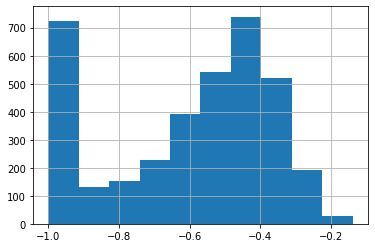

In [ ]:
mts =[]
for i in range(len(nbrs)):
  origional_nm = messy_names[i]
  try:
    matched_nm   = org_names[nbrs[i][0][0]]
    conf         = nbrs[i][1][0]
  except:
    matched_nm   = "no match found"
    conf         = None
  mts.append([origional_nm,matched_nm,conf])

mts = pd.DataFrame(mts,columns=['origional_name','matched_name','conf'])
results = df_CF.merge(mts,left_on='buyer',right_on='origional_name')

results.conf.hist()
#Profile of matches - lower is higher confidence

In [ ]:
https://colab.research.google.com/drive/10ZrZaLBmhEqKSSEoe_cos783m2junUdr?usp=sharing#scrollTo=Bdqu_tJFBD_c

# New Fuzzy

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
fuzzy_merge(df1, df2, 'Key', 'Key', threshold=80)


NameError: name 'wide' is not defined